## Using Resnet50 

In [34]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/HACKER EARTH/images.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finish')


finish


##Importing Necessary libraries

In [35]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from PIL import Image

from keras import layers
from tensorflow.keras import applications 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm




from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

In [6]:
train = pd.read_csv("/content/dataset/train.csv")
train.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [7]:
train.shape

(6469, 2)

In [9]:
#train['Class'].value_counts()
train.groupby(by = "Class").count()

,Image
Class,
Airplane,535
Candle,593
Christmas_Tree,1539
Jacket,640
Miscellaneous,2801
Snowman,361


In [11]:
# useful for getting number ofimages
folders = glob('/content/dataset/train/*')

In [12]:
len(folders)

6469

In [13]:
## set path for images
TRAIN_PATH = '/content/dataset/train/'
TEST_PATH = '/content/dataset/test/'

In [14]:
IMG_SIZE = 64

def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [15]:
train_img = []
for img_name in tqdm(train['Image'].values):
    train_img.append(read_img(TRAIN_PATH + img_name ))
  ##Scaling the image  
x_train = np.array(train_img, np.float32) / 255
print(x_train.shape)

100%|██████████| 6469/6469 [00:01<00:00, 5110.46it/s]


(6469, 64, 64, 3)


In [17]:
class_list = train['Class'].tolist()
class_numeric = {k: v+1 for v, k in enumerate(set(class_list))}
y_train = [class_numeric[k] for k in class_list]
y_train = np.array(y_train)

In [18]:
y_train = to_categorical(y_train)
print(y_train.shape)

(6469, 7)


###Model Building

In [19]:
base_model =   applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [20]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

###Our Model Trains on Our 6 Classes

In [21]:
add_model = Sequential()#sequential layer
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))#flattening
add_model.add(Dropout(0.3))
add_model.add(Dense(128, activation='relu'))
add_model.add(Dropout(0.3))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [22]:
batch_size = 32      
epochs = 50

###Data Augmentation

In [23]:
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen.fit(x_train)

###Training Our Data-image using  Resnet50 Architecture upon 6 classes which our Data Has

In [24]:
history = model.fit_generator( train_datagen.flow(x_train, y_train, batch_size=batch_size),
                               steps_per_epoch=x_train.shape[0] // batch_size,
                               epochs=epochs)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
202/202 [==============================] - 24s 61ms/step - loss: 2.7209 - accuracy: 0.3277
Epoch 2/50
202/202 [==============================] - 12s 59ms/step - loss: 1.2585 - accuracy: 0.5638
Epoch 3/50
202/202 [==============================] - 12s 60ms/step - loss: 1.0233 - accuracy: 0.6477
Epoch 4/50
202/202 [==============================] - 12s 59ms/step - loss: 0.9194 - accuracy: 0.6741
Epoch 5/50
202/202 [==============================] - 12s 60ms/step - loss: 0.8372 - accuracy: 0.7007
Epoch 6/50
202/202 [==============================] - 12s 59ms/step - loss: 0.7373 - accuracy: 0.7459
Epoch 7/50
202/202 [==============================] - 12s 59ms/step - loss: 0.6954 - accuracy: 0.7589
Epoch 8/50
202/202 [==============================] - 12s 59ms/step - loss: 0.6526 - accuracy: 0.7716
Epoch 9/50
202/202 [==============================] - 12s 60ms/step - loss: 0.6540 - accuracy: 0.7656
Epoch 10/50
202/202 [==============================] - 12s 59ms/step - loss: 0.611

In [25]:
import gc
gc.collect()

481

In [26]:
import os

In [27]:
test_images = os.listdir(TEST_PATH)
test_img = []
for image in test_images:
    test_img.append(read_img(TEST_PATH + image))

In [28]:

##Scaling the images
x_test = np.array(test_img, np.float32) / 255
predictions = model.predict(x_test)

In [29]:
predictions = np.argmax(predictions, axis=1)
rev_y = {v:k for k,v in class_numeric.items()}
pred_labels = [rev_y[k] for k in predictions]

In [30]:
data = pd.DataFrame({'Image': test_images, 'Class': pred_labels})
data.to_csv('final_submission.csv', index = False)
data.head(20),data.shape

(            Image           Class
 0    image715.jpg   Miscellaneous
 1   image2029.jpg         Snowman
 2   image6577.jpg   Miscellaneous
 3   image9721.jpg          Jacket
 4   image3077.jpg   Miscellaneous
 5   image4535.jpg        Airplane
 6   image7472.jpg   Miscellaneous
 7   image3584.jpg  Christmas_Tree
 8   image5404.jpg         Snowman
 9   image2992.jpg         Snowman
 10  image5770.jpg          Candle
 11  image8557.jpg  Christmas_Tree
 12  image5871.jpg          Jacket
 13  image8986.jpg   Miscellaneous
 14   image685.jpg   Miscellaneous
 15  image1943.jpg   Miscellaneous
 16  image3526.jpg         Snowman
 17  image5796.jpg   Miscellaneous
 18  image9653.jpg  Christmas_Tree
 19  image1160.jpg   Miscellaneous, (3489, 2))

##This Showws Our Predicted Results is right i.e is Miscellaneous

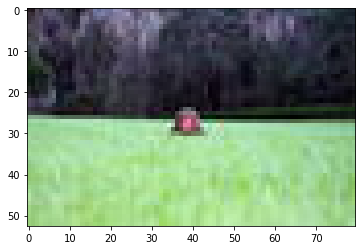

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("/content/dataset/test/image715.jpg")
plt.imshow(image)
plt.show()

In [36]:
data=pd.read_csv('final_submission.csv')

In [37]:
data.head()

,Image,Class
0,image715.jpg,Miscellaneous
1,image2029.jpg,Snowman
2,image6577.jpg,Miscellaneous
3,image9721.jpg,Jacket
4,image3077.jpg,Miscellaneous


In [39]:
data['Class'].value_counts()

Miscellaneous     1516
Christmas_Tree     868
Jacket             377
Candle             295
Airplane           258
Snowman            175
Name: Class, dtype: int64

In [40]:
data.shape

(3489, 2)